# ML Training Pipeline - GitHub Repository Recommendations

This notebook tests our ML recommendation system:
- **Data Loading** from PROJECT_training table
- **Feature Engineering** (TF-IDF, topics, numerical features)
- **Similarity Calculation** (cosine similarity matrix)
- **Model Training & Persistence** 
- **Recommendation Testing** (get similar projects)
- **Performance Evaluation** (initial metrics)


In [1]:
import sys
sys.path.append('../src')

import pandas as pd
import numpy as np
import os

print("🚀 ML Training Pipeline - GitHub Repository Recommendations")
print("=" * 60)
print("Using SQLAlchemy objects for clean architecture")
print("Training data source: PROJECT_training table")
print("=" * 60)


🚀 ML Training Pipeline - GitHub Repository Recommendations
Using SQLAlchemy objects for clean architecture
Training data source: PROJECT_training table


In [2]:
# Feature Engineering Pipeline
from infrastructure.analysis.feature_engineer import FeatureEngineer
from infrastructure.postgres.database import SessionLocal
from domain.models.schema import ProjectTraining

print("=== FEATURE ENGINEERING ===")

# Load data as proper SQLAlchemy objects (clean architecture)
print("Loading ProjectTraining objects from database...")

db = SessionLocal()
try:
    # Query all ProjectTraining objects using SQLAlchemy ORM
    projects_data = db.query(ProjectTraining).all()
    print(f"✅ Loaded {len(projects_data)} ProjectTraining objects")
    
    # Show sample data structure
    if projects_data:
        sample_project = projects_data[0]
        print(f"Sample object: {sample_project.__class__.__name__}")
        print(f"Sample attributes: {list(sample_project.__dict__.keys())}")
        print(f"Sample title: {sample_project.title}")
        print(f"Sample language: {sample_project.language}")
        print(f"Sample description: {sample_project.description[:50]}...")
        
finally:
    db.close()

# Initialize feature engineer
feature_engineer = FeatureEngineer()

print("\nTraining feature engineering pipeline...")
feature_matrix = feature_engineer.fit_transform(projects_data)

print(f"✅ Feature matrix shape: {feature_matrix.shape}")
print(f"✅ Features per project: {feature_matrix.shape[1]}")

# Show feature engineering details
print(f"\n📊 TF-IDF vocabulary size: {len(feature_engineer.tfidf_vectorizer.vocabulary_)}")
print(f"📊 Topics vocabulary size: {len(feature_engineer.topic_encoder.classes_)}")
print(f"📊 Numerical features: {feature_engineer.numerical_features}")

# Sample of top TF-IDF terms
feature_names = feature_engineer.tfidf_vectorizer.get_feature_names_out()
print(f"\nTop 10 TF-IDF terms: {feature_names[:10].tolist()}")


=== FEATURE ENGINEERING ===
Loading ProjectTraining objects from database...
✅ Loaded 1813 ProjectTraining objects
Sample object: ProjectTraining
Sample attributes: ['_sa_instance_state', 'id', 'project_type', 'pushed_at', 'description', 'license', 'created_at', 'vision', 'stars_count', 'github_main_repo', 'language', 'website_url', 'topics', 'difficulty', 'readme', 'status', 'forks_count', 'title', 'is_seeking_contributors', 'open_issues_count']
Sample title: prometheus/node_exporter
Sample language: Go
Sample description: node exporter exporter for machine metrics node ex...

Training feature engineering pipeline...
✅ Feature matrix shape: (1813, 11743)
✅ Features per project: 11743

📊 TF-IDF vocabulary size: 10000
📊 Topics vocabulary size: 1741
📊 Numerical features: ['stars_count', 'open_issues_count']

Top 10 TF-IDF terms: ['00', '00 00', '000', '000 000', '0032', '01', '01 01', '02', '03', '04']


=== SIMILARITY CALCULATION ===
Computing similarity matrix...
✅ Similarity matrix shape: (1813, 1813)
✅ Matrix density: 0.659
✅ Average similarity: 0.0303
✅ Max similarity (excluding diagonal): 1.0000


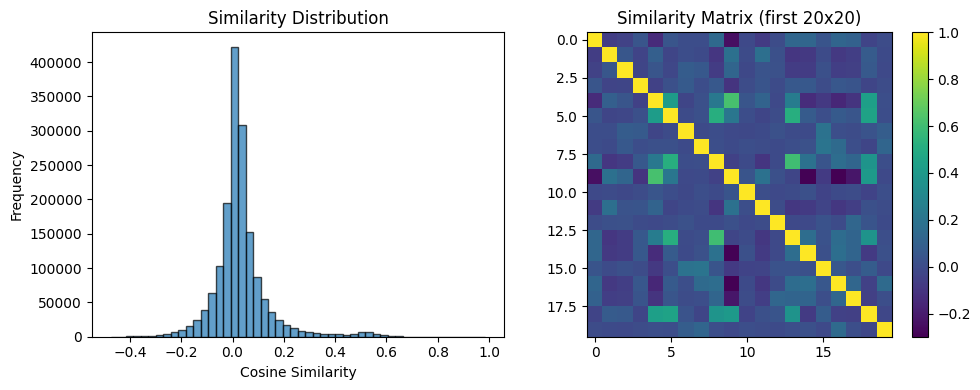


📊 Similarity stats:
   - Mean: 0.0297
   - Std:  0.1092
   - Min:  -0.4752
   - Max:  0.9853


In [3]:
# Similarity Calculation
from infrastructure.analysis.similarity_calculator import SimilarityCalculator

print("=== SIMILARITY CALCULATION ===")

# Initialize similarity calculator
similarity_calculator = SimilarityCalculator()

print("Computing similarity matrix...")
similarity_matrix = similarity_calculator.compute_similarity(feature_matrix)

print(f"✅ Similarity matrix shape: {similarity_matrix.shape}")
print(f"✅ Matrix density: {(similarity_matrix > 0).mean():.3f}")
print(f"✅ Average similarity: {similarity_matrix.mean():.4f}")
print(f"✅ Max similarity (excluding diagonal): {np.fill_diagonal(similarity_matrix.copy(), 0) or similarity_matrix.max():.4f}")

# Show similarity distribution
import matplotlib.pyplot as plt

# Plot similarity distribution
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
# Flatten and remove diagonal (self-similarity = 1.0)
similarities = similarity_matrix[np.triu_indices_from(similarity_matrix, k=1)]
plt.hist(similarities, bins=50, alpha=0.7, edgecolor='black')
plt.title('Similarity Distribution')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
# Heatmap of similarity matrix (sample)
sample_size = min(20, len(similarity_matrix))
sample_matrix = similarity_matrix[:sample_size, :sample_size]
plt.imshow(sample_matrix, cmap='viridis')
plt.title(f'Similarity Matrix (first {sample_size}x{sample_size})')
plt.colorbar()

plt.tight_layout()
plt.show()

print(f"\n📊 Similarity stats:")
print(f"   - Mean: {similarities.mean():.4f}")
print(f"   - Std:  {similarities.std():.4f}")
print(f"   - Min:  {similarities.min():.4f}")
print(f"   - Max:  {similarities.max():.4f}")


In [4]:
# Model Persistence
from infrastructure.analysis.model_persistence_service import ModelPersistenceService

print("=== MODEL PERSISTENCE ===")

# Initialize model persistence service
model_service = ModelPersistenceService()

# Prepare training data and models for saving
training_data = {
    'feature_engineer': feature_engineer,
    'similarity_matrix': similarity_matrix,
    'projects_data': projects_data,
    'feature_matrix': feature_matrix
}

print("Saving trained models...")
model_path = model_service.save_model(training_data, "github_recommendations_v1")

print(f"✅ Models saved to: {model_path}")

# Test model loading
print("\nTesting model loading...")
loaded_data = model_service.load_model("github_recommendations_v1")

print(f"✅ Loaded models:")
print(f"   - Feature engineer: {type(loaded_data['feature_engineer'])}")
print(f"   - Similarity matrix shape: {loaded_data['similarity_matrix'].shape}")
print(f"   - Projects count: {len(loaded_data['projects_data'])}")

# Verify models work after loading
print(f"\n🔧 Model verification:")
print(f"   - TF-IDF vocab size: {len(loaded_data['feature_engineer'].tfidf_vectorizer.vocabulary_)}")
print(f"   - Topics classes: {len(loaded_data['feature_engineer'].topic_encoder.classes_)}")
print(f"   - Similarity matrix max: {loaded_data['similarity_matrix'].max():.4f}")


=== MODEL PERSISTENCE ===
Saving trained models...
Model 'github_recommendations_v1' saved to models/github_recommendations_v1
✅ Models saved to: models/github_recommendations_v1

Testing model loading...
Model 'github_recommendations_v1' loaded from models/github_recommendations_v1
✅ Loaded models:
   - Feature engineer: <class 'infrastructure.analysis.feature_engineer.FeatureEngineer'>
   - Similarity matrix shape: (1813, 1813)
   - Projects count: 1813

🔧 Model verification:
   - TF-IDF vocab size: 10000
   - Topics classes: 1741
   - Similarity matrix max: 1.0000


In [5]:
# Recommendation Testing
print("=== RECOMMENDATION TESTING ===")

def get_recommendations(project_idx, top_k=5):
    """Get top-k similar projects for a given project index"""
    # Get similarity scores for the project
    similarities = similarity_matrix[project_idx]
    
    # Get indices of most similar projects (excluding itself)
    similar_indices = np.argsort(similarities)[::-1][1:top_k+1]
    
    # Get project details
    recommendations = []
    for idx in similar_indices:
        project = projects_data[idx]  # SQLAlchemy object
        score = similarities[idx]
        recommendations.append({
            'project': project,
            'similarity_score': score,
            'index': idx
        })
    
    return recommendations

# Test recommendations for different types of projects
test_projects = [0, 1, 2, 10, 20]  # Sample different projects

for project_idx in test_projects:
    if project_idx >= len(projects_data):
        continue
        
    target_project = projects_data[project_idx]  # SQLAlchemy object
    print(f"\n🎯 TARGET PROJECT:")
    print(f"   Title: {target_project.title}")  # Attribute access
    print(f"   Language: {target_project.language}")
    print(f"   Description: {target_project.description[:100]}...")
    print(f"   Topics: {target_project.topics}")
    
    recommendations = get_recommendations(project_idx, top_k=3)
    
    print(f"\n🔍 TOP 3 RECOMMENDATIONS:")
    for i, rec in enumerate(recommendations, 1):
        proj = rec['project']  # SQLAlchemy object
        score = rec['similarity_score']
        print(f"   {i}. {proj.title} (similarity: {score:.3f})")  # Attribute access
        print(f"      Language: {proj.language} | Topics: {proj.topics}")
        print(f"      Description: {proj.description[:80]}...")
        print()
    
    print("-" * 80)


=== RECOMMENDATION TESTING ===

🎯 TARGET PROJECT:
   Title: prometheus/node_exporter
   Language: Go
   Description: node exporter exporter for machine metrics node exporter circleci bsd workflow golangci lint workflo...
   Topics: prometheus,metrics

🔍 TOP 3 RECOMMENDATIONS:
   1. resilience4j/resilience4j (similarity: 0.493)
      Language: Java | Topics: metrics
      Description: resilience4j resilience4j is a fault tolerance library designed for java8 and fu...

   2. thanos-io/thanos (similarity: 0.346)
      Language: Go | Topics: prometheus,google-cloud-storage,high-availability,thanos,s3,storage,cncf,go,metrics,monitoring,observability,hacktoberfest
      Description: thanos highly available prometheus setup with long term storage capabilities a c...

   3. apache/skywalking (similarity: 0.328)
      Language: Java | Topics: skywalking,observability,apm,service-mesh,dapper,distributed-tracing,web-performance,metrics,logging,prometheus,ebpf,telegraf
      Description: skywalkin

In [6]:
# Performance Evaluation
print("=== PERFORMANCE EVALUATION ===")

def evaluate_language_consistency(num_samples=50):
    """Evaluate how often recommendations match the target project's language"""
    matches = 0
    total_recommendations = 0
    
    # Sample random projects for evaluation
    sample_indices = np.random.choice(len(projects_data), num_samples, replace=False)
    
    for idx in sample_indices:
        target_language = projects_data[idx].language  # SQLAlchemy object attribute
        recommendations = get_recommendations(idx, top_k=5)
        
        for rec in recommendations:
            total_recommendations += 1
            if rec['project'].language == target_language:  # SQLAlchemy object attribute
                matches += 1
    
    return matches / total_recommendations if total_recommendations > 0 else 0

def evaluate_topic_overlap(num_samples=50):
    """Evaluate average topic overlap between target and recommended projects"""
    total_overlap = 0
    total_comparisons = 0
    
    sample_indices = np.random.choice(len(projects_data), num_samples, replace=False)
    
    for idx in sample_indices:
        target_topics = set(projects_data[idx].topics.split(',')) if projects_data[idx].topics else set()  # SQLAlchemy object
        recommendations = get_recommendations(idx, top_k=5)
        
        for rec in recommendations:
            rec_topics = set(rec['project'].topics.split(',')) if rec['project'].topics else set()  # SQLAlchemy object
            
            if target_topics and rec_topics:
                overlap = len(target_topics.intersection(rec_topics)) / len(target_topics.union(rec_topics))
                total_overlap += overlap
                total_comparisons += 1
    
    return total_overlap / total_comparisons if total_comparisons > 0 else 0

# Run evaluations
print("Evaluating recommendation quality...")

language_consistency = evaluate_language_consistency(num_samples=100)
topic_overlap = evaluate_topic_overlap(num_samples=100)

print(f"\n📊 RECOMMENDATION QUALITY METRICS:")
print(f"   🎯 Language Consistency: {language_consistency:.3f} ({language_consistency*100:.1f}%)")
print(f"   🏷️  Average Topic Overlap: {topic_overlap:.3f} ({topic_overlap*100:.1f}%)")

# Diversity analysis
similarity_threshold = 0.1
diverse_pairs = (similarity_matrix > similarity_threshold).sum() - len(similarity_matrix)  # Exclude diagonal
total_pairs = len(similarity_matrix) * (len(similarity_matrix) - 1)
diversity_score = 1 - (diverse_pairs / total_pairs)

print(f"   🌈 Diversity Score: {diversity_score:.3f} (lower = more diverse)")

# Summary
print(f"\n✅ TRAINING PIPELINE SUMMARY:")
print(f"   📁 Projects processed: {len(projects_data)}")
print(f"   🔧 Feature dimensions: {feature_matrix.shape[1]}")
print(f"   🎯 Similarity matrix: {similarity_matrix.shape}")
print(f"   💾 Model saved: github_recommendations_v1")
print(f"   📊 Language consistency: {language_consistency*100:.1f}%")
print(f"   🏷️  Topic overlap: {topic_overlap*100:.1f}%")


=== PERFORMANCE EVALUATION ===
Evaluating recommendation quality...

📊 RECOMMENDATION QUALITY METRICS:
   🎯 Language Consistency: 0.640 (64.0%)
   🏷️  Average Topic Overlap: 0.232 (23.2%)
   🌈 Diversity Score: 0.861 (lower = more diverse)

✅ TRAINING PIPELINE SUMMARY:
   📁 Projects processed: 1813
   🔧 Feature dimensions: 11743
   🎯 Similarity matrix: (1813, 1813)
   💾 Model saved: github_recommendations_v1
   📊 Language consistency: 64.0%
   🏷️  Topic overlap: 23.2%
